# Figure 3

## Jeonghyeon Kim

In [1]:
import os
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import fisher_exact
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pybedtools
from collections import defaultdict

In [2]:
import sys
import scipy
print("python version", sys.version)
print("pandas version", pd.__version__)
print("scipy version", scipy.__version__)

python version 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
pandas version 1.4.3
scipy version 1.10.0


In [3]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.3.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 7.2.2
jupyter_core     : 4.10.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.11
qtconsole        : 5.3.0
traitlets        : 5.1.1


## Paths

In [4]:
data_dir       = "../"
pickle_dir     = os.path.join(data_dir, "pickles/")
dataset_dir    = os.path.join(data_dir, "datasets/")

In [13]:
alu_cols       = ['chrom', 'start', 'end', 'subfamily', 'id']

hs_alu_file    = os.path.join(dataset_dir, "liftover_total.tsv")
hs_alu_df      = pd.read_csv(hs_alu_file, sep='\t', header=None, usecols=[0,1,2,3,4], names=alu_cols)

total_alu_file = os.path.join(dataset_dir, "SINE_Alu_sorted.bed")
total_alu_df   = pd.read_csv(total_alu_file, sep='\t', header=None, usecols=[0,1,2,3,14], names=alu_cols)

hg38_chr_len_file = os.path.join(dataset_dir, "chr_file.bed")
hg38_chr_len      = pd.read_csv(hg38_chr_len_file, sep='\t', names=['chrom','length'], usecols=[0,2])

In [14]:
print(f"The number of hominoid specific Alus: {len(hs_alu_df)}")
print(f"The number of total Alus            : {len(total_alu_df)}")

The number of hominoid specific Alus: 67126
The number of total Alus            : 1181164


## Figure 3-C

In [19]:
def process_data(alu_data):
    # Step 1: Split data into subfamilies AluJ, AluS, AluY, and others
    # Creates a dictionary with each subfamily's data as a separate dataframe
    alu_subfamilies = {
        'AluJ': alu_data[alu_data['subfamily'].str.startswith('AluJ')],
        'AluS': alu_data[alu_data['subfamily'].str.startswith('AluS')],
        'AluY': alu_data[alu_data['subfamily'].str.startswith('AluY')],
        # The tilde (~) operator creates a NOT condition for elements not in any of the above families
        'Others': alu_data[~alu_data['subfamily'].str.startswith(('AluJ', 'AluS', 'AluY'))]
    }

    # Step 2: Calculate the sum of lengths for each chromosome within each subfamily
    # Creates a nested defaultdict to store lengths: {chromosome -> {subfamily -> length}}
    alu_lengths = defaultdict(lambda: defaultdict(int))
    for subfamily, df in alu_subfamilies.items():
        for chrom, chrom_data in df.groupby('chrom'):
            # Calculate total length by summing (end - start) for each element
            total_length = (chrom_data['end'] - chrom_data['start']).sum()
            alu_lengths[chrom][subfamily] = total_length

    # Step 3: Create dictionary of chromosome lengths from the provided data
    chrom_lengths = {
        chrom: int(hg38_chr_len.loc[hg38_chr_len['chrom'] == chrom, 'length'].values[0])
        for chrom in hg38_chr_len['chrom'].unique()
    }

    # Step 4: Calculate coverage (Alu length / chromosome length) for each subfamily
    coverage_results = defaultdict(dict)
    for chrom, subfam_lengths in alu_lengths.items():
        for subfamily, length in subfam_lengths.items():
            coverage_results[chrom][subfamily] = length / chrom_lengths[chrom]

    # Step 5: Create and format the final dataframe
    # Convert coverage results to dataframe and fill NA values with 0
    coverage_df = pd.DataFrame(coverage_results).T.fillna(0)
    # Merge with chromosome length data
    coverage_df = hg38_chr_len.merge(
        coverage_df.reset_index().rename(columns={'index':'chrom'}),
        on='chrom'
    )

    # Step 6: Calculate genome-wide average coverage
    total_genome_length = coverage_df['length'].sum()
    # Weight each chromosome's coverage by its length
    avg_coverage = {
        subfamily: (coverage_df[subfamily] * coverage_df['length']).sum() / total_genome_length
        for subfamily in ['AluJ', 'AluS', 'AluY', 'Others']
    }
    
    # Add genome-wide averages as a new row
    avg_coverage["chrom"] = "Genome"
    coverage_df = coverage_df.append(avg_coverage, ignore_index=True)
    coverage_df = coverage_df.set_index('chrom')
    
    return coverage_df

In [20]:
coverage_df_all = process_data(total_alu_df)
coverage_df_hs = process_data(hs_alu_df)
coverage_df_ratio = coverage_df_hs/coverage_df_all

/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/3975691659.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coverage_df = coverage_df.append(avg_coverage, ignore_index=True)
/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/3975691659.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coverage_df = coverage_df.append(avg_coverage, ignore_index=True)


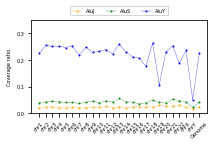

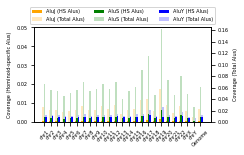

In [21]:
# Define custom colors for each subfamily
subfamily_colors = {'AluJ': 'orange', 'AluS': 'green', 'AluY': 'blue'}

# Ensure chromosome ordering
chrom_order = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY", "Genome"]
coverage_df_ratio = coverage_df_ratio.loc[chrom_order]

# Plotting all Alu subfamilies on the same plot for each chromosome
plt.figure(figsize=(3.1, 2.2))  # Set width to 6 (same width for both plots)
for subfamily in ['AluJ', 'AluS', 'AluY']:
    plt.plot(coverage_df_ratio.index, coverage_df_ratio[subfamily], marker='o', markersize=1, linewidth=0.3,
             color=subfamily_colors[subfamily], label=subfamily)

plt.ylabel("Coverage ratio", fontsize=5)
#plt.title("Alu Coverage Ratio (Hominoid-specific Alus / Total Alus)", fontsize=5)
plt.xticks(rotation=45, fontsize=5)
plt.yticks(fontsize=5)
plt.ylim(0, 0.35)
plt.legend(fontsize=5, loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=3)
plt.tight_layout()
plt.savefig('./coverage_ratio.svg', format="svg")

plt.show()

# Assuming you have coverage_df_hs and coverage_df_all dataframes properly set up
coverage_df_hs = coverage_df_hs.loc[chrom_order]
coverage_df_all = coverage_df_all.loc[chrom_order]

# Bar plot
fig, ax1 = plt.subplots(figsize=(3.5, 2))  # Ensure same width
bar_width = 0.23  # Adjust this width to match the plot visually
x = np.arange(len(coverage_df_hs.index))  # the label locations

# Plotting each subfamily's coverage on the primary y-axis with full opacity
for i, subfamily in enumerate(['AluJ', 'AluS', 'AluY']):
    ax1.bar(x + i * bar_width, coverage_df_hs[subfamily], width=bar_width, 
            color=subfamily_colors[subfamily], label=subfamily)

ax1.set_ylabel("Coverage (Hominoid-specific Alus)", fontsize=5)
#ax1.set_title("Alu Coverage Proportion by Chromosome for All Subfamilies", fontsize=5)
ax1.set_xticks(x + bar_width)  # Adjust for bar width
ax1.set_xticklabels(coverage_df_hs.index, rotation=45, fontsize=5)
ax1.set_ylim(0, 0.05)
ax1.tick_params(axis='y', labelsize=5)

# Create a secondary y-axis for total coverage values, with transparent colors
ax2 = ax1.twinx()
for i, subfamily in enumerate(['AluJ', 'AluS', 'AluY']):
    ax2.bar(x + i * bar_width, coverage_df_all[subfamily], width=bar_width, 
            color=subfamily_colors[subfamily], alpha=0.25, label=subfamily)

# Set custom limits for the second y-axis
total_coverage_min = 0  # Adjust based on minimum value for total coverage
total_coverage_max = max(coverage_df_all[['AluJ', 'AluS', 'AluY']].max()) * 1.02  # Adjust based on data
ax2.set_ylim(total_coverage_min, total_coverage_max)

ax2.set_ylabel("Coverage (Total Alus)", fontsize=5)
ax2.tick_params(axis='y', labelsize=5)

# Move legend to the upper center inside the plot
handles_hs, _ = ax1.get_legend_handles_labels()  # Handles for the primary axis (hominoid-specific)
handles_total, _ = ax2.get_legend_handles_labels()  # Handles for the secondary axis (total)

# Create custom ordered handles and labels
handles = [
    handles_hs[0],  # AluJ (Hominoid-specific Alus)
    handles_total[0],  # AluJ (Total Alus)
    handles_hs[1],  # AluS (Hominoid-specific Alus)
    handles_total[1],  # AluS (Total Alus)
    handles_hs[2],  # AluY (Hominoid-specific Alus)
    handles_total[2]   # AluY (Total Alus)
]

# Corresponding labels should follow the same order
combined_labels = [
    'AluJ (HS Alus)',
    'AluJ (Total Alus)',
    'AluS (HS Alus)',
    'AluS (Total Alus)',
    'AluY (HS Alus)',
    'AluY (Total Alus)'
]

# Set legend with specified handles and labels. Use ncol=3 to have three columns.
fig.legend(handles, combined_labels, fontsize=5, title_fontsize=5, loc='upper center',bbox_to_anchor=(0.5, 1.07), ncol=3)

# Adjust layout to improve spacing
plt.subplots_adjust(right=0.85)  # Adjust this value if needed
plt.tight_layout()
#plt.savefig('./Fig3c.svg', format="svg")
plt.show()

## Figure 3-D

In [22]:
def swarmplot_p_values(results_df, title=None, log=False, use_string=False, 
                       legend=True, legend_pos="bottom", ylabel=True, ax=None):
    """ Plot (log scale) p-values where bonferroni_reject_greater is True 
    (reached statistical significance of one-tailed FE test after Bonferonni correction).
    """
    #sns.set_theme()
    sns.set_theme(font_scale=1.2)
    sns.set_style('ticks')
    
    cmap = plt.get_cmap('Spectral')
    n_colors = 10  # Number of discrete colors
    colors = [cmap(i) for i in np.linspace(0, 1, n_colors)]
    bidirectional_palette = sns.color_palette(colors)
    
    if not ax:
        fig, ax = plt.subplots(figsize=(1,4))
    
    results_df['window'] = results_df['window'].astype('category')
    results_df["bonferroni_p_greater_neglog10"] = -np.log10(results_df["Bonferroni_Corrected_P_Value"])
    
    if not use_string:
        x_col = "Subfamily"
    elif use_string:
        x_col = "Subfamily"
    sns.swarmplot(x=x_col, y="bonferroni_p_greater_neglog10", hue="window", s=7, dodge=False,
                  data=results_df, 
                  palette=bidirectional_palette, ax=ax) #y="bonferroni_p_greater"
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    ax.xaxis.grid(True)
    ax.set_ylim(0,2)
    ax.axhline(y=-np.log10(0.05), color='steelblue', linestyle='--')
    
    if ylabel:
        if log:
            #ax.set_yscale('log')
            #ax.set_ylabel("Bonferroni-corrected p-value \n(alternative: greater)") # log(bonferroni_p_greater)
            ax.set_ylabel("-log10(p_adj)") # log(bonferroni_p_greater)
        else:
            ax.set_ylabel("Bonferroni-corrected p-value \n(alternative: greater)")
    else:
        ax.set_ylabel(None)


    all_window_sizes = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

        # Create custom legend handles
    legend_handles = [Line2D([0], [0], marker='o', color='w', label=f'{ws}',
                            markerfacecolor=col, markersize=10) for col, ws in zip(colors, all_window_sizes)]
    #ax.set_xlabel("Alu subfamily")
    ax.set_xlabel(None)
    if title:
        plt.title("{}".format(title))
    
    if legend:
        if legend_pos == "bottom":
            # ref: https://stackoverflow.com/questions/4700614
            ax.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.52), #(0.5, -0.4)
                      ncol=5, fancybox=True, shadow=False, borderaxespad=0., 
                      fontsize=5, title="Window (bp)")
        elif legend_pos == "right":
            ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(2.1,1.0), # (1.13, 0.1)
                      ncol=1, fancybox=True, shadow=False, borderaxespad=0., 
                      fontsize=10, title="Window (bp)")
    else:
        ax.legend([])


def extract_window(df,window):
    df = df[df.downstream_dist >= -window]
    df = df[df.upstream_dist <= window]
    
    return df

def extract_hominoid(dataframe, hs_alu_df):
    keep_cols = ['exon_chr', 'exon_start', 'exon_end', 'exon_gene', 'exon_strand', 'upstream_alu_id', 'upstream_alu_start', 'upstream_alu_end', 'upstream_alu_strand',  'upstream_alu_subfamily', 'upstream_dist', 
                                                                                'downstream_alu_id', 'downstream_alu_start', 'downstream_alu_end', 'downstream_alu_strand', 'downstream_alu_subfamily', 'downstream_dist']

    dataframe = dataframe[keep_cols]
    hs_alu_upstream_df = pd.merge(dataframe, hs_alu_df['id'], how='inner', left_on=['upstream_alu_id'], right_on='id') 
    hs_alu_downstream_df = pd.merge(dataframe, hs_alu_df['id'], how='inner', left_on=['downstream_alu_id'], right_on='id')

    hs_IR_alu_df = pd.concat([hs_alu_upstream_df,hs_alu_downstream_df], ignore_index=True)
    hs_IR_alu_df = hs_IR_alu_df.drop_duplicates(['exon_chr', 'exon_start', 'exon_end', 'exon_gene', 'exon_strand', 'upstream_alu_subfamily', 'downstream_alu_subfamily', 'upstream_alu_start', 'upstream_alu_end', 'downstream_alu_start', 'downstream_alu_end'])

    return hs_IR_alu_df

def merge_updown(IR_all):
    # Merges upstream and downstream Alu IDs and subfamilies into a single DataFrame
    upstream = IR_all[['upstream_alu_id', 'upstream_alu_subfamily']].rename(columns={'upstream_alu_id':'id', 'upstream_alu_subfamily':'subfamily'})
    downstream = IR_all[['downstream_alu_id', 'downstream_alu_subfamily']].rename(columns={'downstream_alu_id':'id', 'downstream_alu_subfamily':'subfamily'})
    
    return pd.concat([upstream, downstream])

def count_alu_subfamily(all_alu):
    # Merge upstream and downstream Alu subfamilies, then count occurrences
    all_alu = merge_updown(all_alu).drop_duplicates()
    return pd.DataFrame(all_alu.groupby('subfamily').size(), columns=['count'])

def count_alu_pair(data):
    # Count occurrences of (upstream_subfamily, downstream_subfamily) pairs
    data['alu_pair'] = data.apply(lambda x: (x['upstream_alu_subfamily'], x['downstream_alu_subfamily']), axis=1)
    return pd.DataFrame(data.groupby('alu_pair').size(), columns=['count'])

def prepare_data(new_data, window, hs_alu_df):
    # Extract skippable and constitutive inverted repeat data within the window
    IR_skippable = extract_window(new_data["skippable_inverted"], window)
    IR_const = extract_window(new_data["constitutive_inverted"], window)
    
    # Extract hominoid (human-specific) data
    hs_IR_skippable = extract_hominoid(IR_skippable, hs_alu_df)
    hs_IR_const = extract_hominoid(IR_const, hs_alu_df)
    
    # Merge the data to identify non-human-specific (non-hs) and human-specific (hs) entries
    merged_skippable = IR_skippable.merge(hs_IR_skippable, on=['downstream_alu_id', 'upstream_alu_id'], how='left', indicator=True).rename(columns={'downstream_alu_subfamily_x':'downstream_alu_subfamily','upstream_alu_subfamily_x':'upstream_alu_subfamily'})
    merged_constitutive = IR_const.merge(hs_IR_const, on=['downstream_alu_id', 'upstream_alu_id'], how='left', indicator=True).rename(columns={'downstream_alu_subfamily_x':'downstream_alu_subfamily','upstream_alu_subfamily_x':'upstream_alu_subfamily'})
    
    # Filter non-human-specific entries
    non_hs_skippable = merged_skippable[merged_skippable['_merge'] == 'left_only'].drop(columns=['_merge'])
    non_hs_const = merged_constitutive[merged_constitutive['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    return non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const

def create_count_table_helper(non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const, count_function):
    # Count occurrences for non-human-specific (non-hs) and human-specific (hs) data
    non_hs_skippable_count = count_function(non_hs_skippable)
    non_hs_const_count = count_function(non_hs_const)
    hs_skippable_count = count_function(hs_IR_skippable)
    hs_const_count = count_function(hs_IR_const)
    
    # Rename columns to reflect count categories
    non_hs_skippable_count.rename(columns={'count': 'IR_skippable'}, inplace=True)
    hs_skippable_count.rename(columns={'count': 'hs_IR_skippable'}, inplace=True)
    non_hs_const_count.rename(columns={'count': 'IR_const'}, inplace=True)
    hs_const_count.rename(columns={'count': 'hs_IR_const'}, inplace=True)
    
    # Join all counts into a single table
    return non_hs_skippable_count.join(hs_skippable_count, how='outer').join(non_hs_const_count, how='outer').join(hs_const_count, how='outer').fillna(0)

def create_count_table_single(new_data, window, hs_alu_df):
    # Prepare data for skippable and constitutive IRs
    non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const = prepare_data(new_data, window, hs_alu_df)
    
    # Use the helper function to generate the count table for Alu subfamilies
    return create_count_table_helper(non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const, count_alu_subfamily)

def create_count_table_pair(new_data, window, hs_alu_df):
    # Prepare data for skippable and constitutive IRs
    non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const = prepare_data(new_data, window, hs_alu_df)
    
    # Use the helper function to generate the count table for Alu pairs
    return create_count_table_helper(non_hs_skippable, non_hs_const, hs_IR_skippable, hs_IR_const, count_alu_pair)

def create_p_val_table(dataframe):
    p_values = []
    
    for i, subfamily in enumerate(dataframe.index):
        # Extract counts for the current subfamily across categories
        values = dataframe.iloc[i].values
        
        # Create a 2x2 contingency table (for demonstration, split in half)
        contingency_table = np.array([
            [values[1], values[3]],
            [values[0], values[2]]
        ])
        
        # Perform chi-squared test
        _, p_val = fisher_exact(contingency_table, alternative='greater')
        p_values.append(p_val)

    # Apply Bonferroni correction
    bonferroni_corrected_p_values = [min(p * len(p_values), 1) for p in p_values]

    # Create a DataFrame with results
    return pd.DataFrame({
        'Subfamily': dataframe.index,
        'P_Value': p_values,
        'Bonferroni_Corrected_P_Value': bonferroni_corrected_p_values
    })

def stack_p_tables(p_table):
    stacked_table = pd.concat(
                    [p_table[window][1].assign(window=window) for window in p_table.keys()]
                    ).query("Bonferroni_Corrected_P_Value != 1.0")
    stacked_table["Subfamily"] = stacked_table["Subfamily"].astype('str')
    
    return stacked_table


In [26]:
alu_cols       = ['chr', 'start', 'end', 'subfamily', 'id']

hs_alu_file    = os.path.join(dataset_dir, "liftover_total.tsv")
hs_alu_df      = pd.read_csv(hs_alu_file, sep='\t', header=None, usecols=[0,1,2,3,4], names=alu_cols)

closest_exon_to_alu_file = os.path.join(pickle_dir, "240129-test_windows_subset.pkl")
closest_exon_to_alu_df = pd.read_pickle(closest_exon_to_alu_file)

In [25]:
result_single = {}
result_pair   = {}

windows = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000]

for window in windows:
    count_table_single = create_count_table_single(closest_exon_to_alu_df, window, hs_alu_df)
    result_table_single = create_p_val_table(count_table_single)
    result_single[window] = [count_table_single, result_table_single]
    
    count_table_pair = create_count_table_pair(closest_exon_to_alu_df, window, hs_alu_df)
    result_table_pair = create_p_val_table(count_table_pair)
    result_pair[window] = [count_table_pair, result_table_pair]
    
enrichment_single = stack_p_tables(result_single)
enrichment_pair   = stack_p_tables(result_pair)

/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/1221205494.py:25: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.swarmplot(x=x_col, y="bonferroni_p_greater_neglog10", hue="window", s=7, dodge=False,
/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/1221205494.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/1221205494.py:25: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.swarmplot(x=x_col, y="bonferroni_p_greater_neglog10", hue="window", s=7, dodge=False,
/var/folders/b9/2y20mh5s2yd2qvr04y0hh8bh0000gn/T/ipykernel_53707/1221205494.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


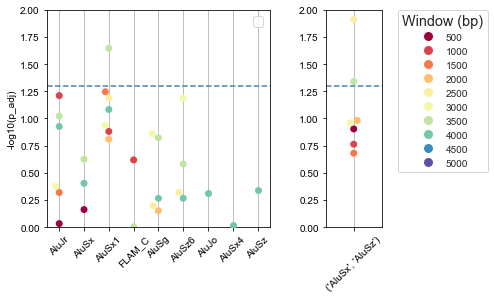

In [27]:
width_ratios = [2, 0.5]
fig, axs = plt.subplots(1, 2, figsize=(6,4), gridspec_kw={'width_ratios': width_ratios, 'hspace': 0.25, 'wspace': 0.4})

swarmplot_p_values(enrichment_single, title=None, log=True, legend=False, ax=axs[0])
swarmplot_p_values(enrichment_pair, title=None, log=True, use_string=True, legend=True, legend_pos="right", ylabel=False, ax=axs[1])
#plt.savefig('./Figure3d.svg', format="svg")
plt.show()